# Importing required libraries

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Importing the dataset

In [2]:
filename = '/home/shailesh/Desktop/fuse-project-1/dataset/orginal_dataset/pd_speech_features.csv'
dataframe = pd.read_csv(filename)
dataframe.shape

(756, 755)

In [3]:
dataframe.head()

,id,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,...,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
0,0,1,0.85247,0.71826,0.57227,240,239,0.008064,0.000087,0.00218,...,1.5620,2.6445,3.8686,4.2105,5.1221,4.4625,2.6202,3.0004,18.9405,1
1,0,1,0.76686,0.69481,0.53966,234,233,0.008258,0.000073,0.00195,...,1.5589,3.6107,23.5155,14.1962,11.0261,9.5082,6.5245,6.3431,45.1780,1
2,0,1,0.85083,0.67604,0.58982,232,231,0.008340,0.000060,0.00176,...,1.5643,2.3308,9.4959,10.7458,11.0177,4.8066,2.9199,3.1495,4.7666,1
3,1,0,0.41121,0.79672,0.59257,178,177,0.010858,0.000183,0.00419,...,3.7805,3.5664,5.2558,14.0403,4.2235,4.6857,4.8460,6.2650,4.0603,1
4,1,0,0.32790,0.79782,0.53028,236,235,0.008162,0.002669,0.00535,...,6.1727,5.8416,6.0805,5.7621,7.7817,11.6891,8.2103,5.0559,6.1164,1


# Data Extraction from the dataset

Baseline Features: Column-3 to Column-23
Intensity Parameters: Col24 to Col26
Formant Frequencies: Col27 to Col30
Bandwidth Parameters: Col31 to Col34
Vocal Fold: Col35 to Col56
MFCC: Col57 to Col140
Wavelet Features: Col141 to Col322
TQWT Features: Col323 to Col754
Class: Col755

Refer Research Page: 6 - 9

In [4]:
baseline = dataframe.iloc[:,2:23]
intensity = dataframe.iloc[:,23:26]
frequency = dataframe.iloc[:,26:30]
bandwidth = dataframe.iloc[:,30:34]
vocal = dataframe.iloc[:,34:56]
mfcc = dataframe.iloc[:,56:140]
wavelet = dataframe.iloc[:,140:322]
tqwt = dataframe.iloc[:,322:754]
y = dataframe.iloc[:,754:755]

### Baseline Columns

In [5]:
mean_value_columns = [cols for cols in baseline.columns if cols.__contains__('mean')]
std_value_columns = [cols for cols in baseline.columns if cols.__contains__('std')]
other_columns = list(set(baseline.columns) - set(mean_value_columns) - set(std_value_columns))

After Going through the paper, we can see that the baseline features and time frequency features are the most important features.

In [6]:
# Shailesh: getting dataframe with only baseline and time frequency features
extracted_df = baseline[other_columns].join([intensity,frequency,bandwidth])
extracted_df.shape

(756, 27)

In [7]:
extracted_df.head()

,locDbShimmer,ddaShimmer,numPeriodsPulses,numPulses,rapJitter,apq3Shimmer,PPE,RPDE,locAbsJitter,ppq5Jitter,...,maxIntensity,meanIntensity,f1,f2,f3,f4,b1,b2,b3,b4
0,0.517,0.09034,239,240,0.00067,0.03011,0.85247,0.57227,0.000018,0.00129,...,76.088046,72.465512,539.342735,1031.849040,2447.162183,3655.054806,101.092218,83.147440,255.214830,396.643631
1,0.502,0.06961,233,234,0.00052,0.02320,0.76686,0.53966,0.000016,0.00112,...,73.046374,71.528945,564.363615,1016.367294,2383.565201,3498.681572,58.465428,86.487292,248.357127,218.229722
2,0.897,0.15282,231,232,0.00057,0.05094,0.85083,0.58982,0.000015,0.00111,...,71.633549,68.086583,548.444604,1032.406341,2357.826954,3678.128717,160.387771,54.685168,151.694847,84.240339
3,0.527,0.07185,177,178,0.00149,0.02395,0.41121,0.59257,0.000046,0.00268,...,81.000749,79.190593,819.529588,1201.813897,3154.035654,4122.163933,238.667052,191.984916,573.752909,526.147599
4,0.497,0.08728,235,236,0.00166,0.02909,0.32790,0.53028,0.000044,0.00227,...,80.937258,79.183495,846.796144,1215.346469,3201.513132,4085.456839,402.216738,210.061394,203.637106,384.611697


# Data Preprocessing and Visualization

In [53]:
def draw_correlation_matrix(df:pd.DataFrame) -> None:
    """
    This function draws the correlation matrix of the given dataframe.

    :param df: pd.DataFrame
    :return: None
    """
    # Create the correlation matrix
    corr = df.corr().round(3)

    # Generate a mask for the upper triangle; True = do NOT show
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.tril_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(26, 10))
    # want a more natural, table-like display
    ax.invert_yaxis()
    ax.xaxis.tick_top()

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(
        corr,          # The data to plot
        mask=mask,     # Mask some cells
        annot=True,    # Should the values be plotted in the cells?
        vmax=1, vmin=-1, center=0,
        square=False, linewidths=.5,
        cbar_kws={"shrink": .5}  # Extra kwargs for the legend; in this case, shrink by 50%
    )

/tmp/ipykernel_43249/2316084390.py:12: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


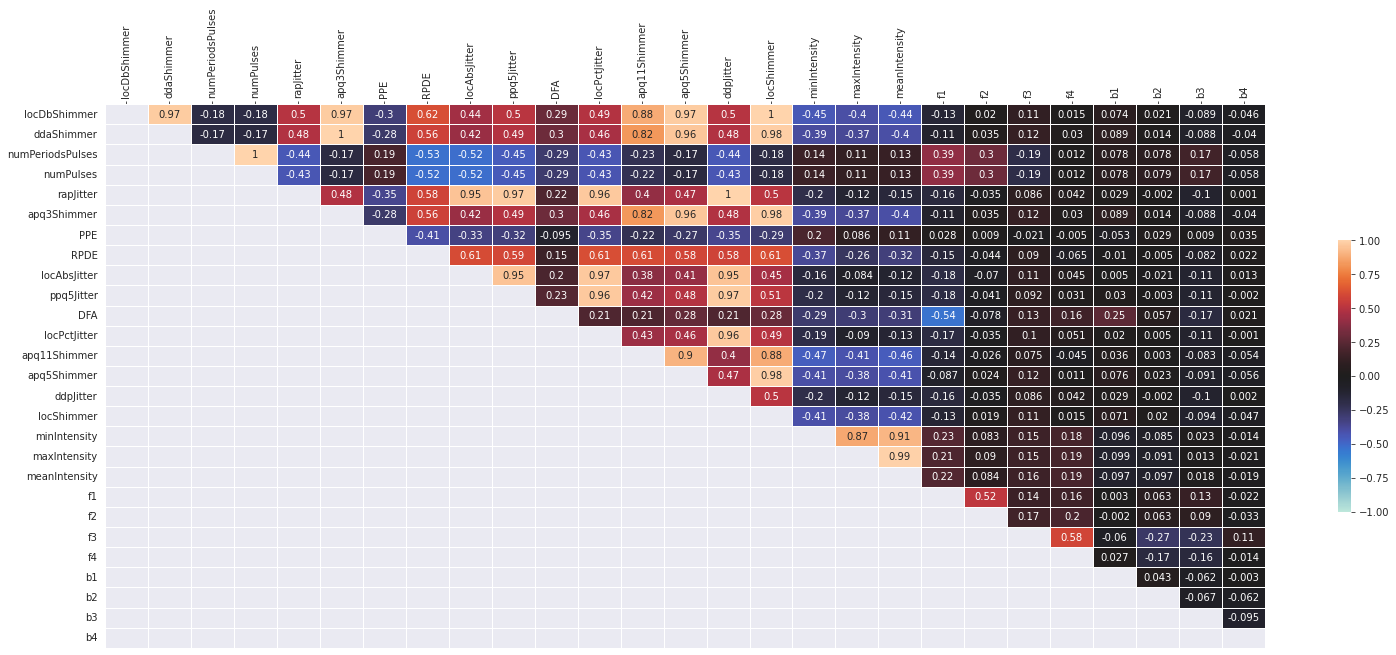

In [54]:
draw_correlation_matrix(extracted_df)

Highly Correlated Features :

1. meanintensity and **minintensity**
2. **locShimmer** and locDbShimmer
3. **locShimmer** and apq5Shimmer
4. ddpJitter and rapJitter
5. apq3Shimmer and ddaShimmer
6. numPulses and **numPeriodsPluses**